 1. Import Required Libraries

In [2]:
# This section imports the core libraries required for building and evaluating the image classification model.
# 
# - TensorFlow and Keras modules are used for constructing, training, and evaluating the convolutional neural network (CNN).
# - ImageDataGenerator is used for preprocessing and augmenting image data, which helps improve model generalization.
# - sklearn.metrics.classification_report is used to generate a detailed report of classification metrics after model evaluation.
# - os and numpy are used for file handling and numerical operations, respectively.
# - matplotlib.pyplot is used for visualizing images and results.
#
# These imports are essential for the workflow: loading and preprocessing image data, building the model, training, evaluating, and visualizing results.

In [ ]:
# TensorFlow and model building
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

# For data handling and visualization
import os
import numpy as np
import matplotlib.pyplot as plt


2. Set Paths and Hyperparameters

In [ ]:
# This section sets the paths to the dataset directories and defines key hyperparameters for the model.
#
# - `data_dir`, `train_path`, and `test_path` specify where the training and testing images are stored. These paths are used by the data generators to load images directly from the folder structure.
# - `img_size` determines the target size to which all images will be resized. This ensures consistency in input shape for the neural network.
# - `batch_size` defines how many images are processed together in one batch during training and evaluation. A suitable batch size helps balance memory usage and training speed.
#
# Setting these variables at the start makes it easy to manage and modify dataset locations and model parameters throughout the notebook.

In [2]:
# Path to the dataset 
data_dir = './data_split'
train_path = os.path.join(data_dir, 'train')
test_path = os.path.join(data_dir, 'test')
img_size = (240, 240)
batch_size = 32


<h3> Step 3: Data Preprocessing </h3>


In [ ]:
# Data Preprocessing Section
# 
# In this section, we prepare the image data for training, validation, and testing.
# We use TensorFlow's ImageDataGenerator to:
#   - Rescale pixel values to the [0, 1] range for better model convergence.
#   - Apply data augmentation (rotation, zoom, horizontal flip) to the training set to improve generalization and reduce overfitting.
#   - Generate batches of images and labels directly from the directory structure.
#
# The generators are configured as follows:
#   - train_datagen: Applies augmentation and rescaling to the training images.
#   - train_data: Loads augmented training images in batches.
#   - val_data: Loads validation images (from the same directory) for model evaluation during training.
#   - test_datagen and test_data: Only rescale test images for final evaluation, without augmentation.
#
# This approach is efficient for handling large datasets and ensures that the model sees a variety of images during training.

In [8]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    validation_split=0.2,
    horizontal_flip=True)
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 12648 images belonging to 10 classes.
Found 3158 images belonging to 10 classes.
Found 3956 images belonging to 10 classes.


 Step 4: Build CNN Model

In [ ]:
This section constructs the Convolutional Neural Network (CNN) architecture for image classification.

**Why:**  
A CNN is well-suited for image classification tasks because it can automatically learn spatial hierarchies of features from input images. By stacking convolutional and pooling layers, the model captures low-level to high-level visual patterns, making it effective for distinguishing between different waste categories.

**How:**  
- The model is built using Keras' Sequential API, stacking layers in order.
- Multiple `Conv2D` and `MaxPooling2D` layers extract features and reduce spatial dimensions.
- The `Flatten` layer converts the 2D feature maps into a 1D vector.
- Dense layers perform classification based on the extracted features.
- The final Dense layer uses softmax activation to output class probabilities.
- The model is compiled with the Adam optimizer, categorical cross-entropy loss (for multi-class classification), and accuracy as the evaluation metric.

This architecture balances complexity and efficiency, making it suitable for the given image classification problem.

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 238, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 119, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 117, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,722 (49.36 MB)

 Trainable params: 12,939,722 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Step 5: Train Model

In [ ]:
This section trains the CNN model using the prepared training and validation datasets.

**Why:**  
Training allows the model to learn patterns and features from the labeled images, adjusting its internal parameters to minimize classification errors.

**How:**  
- The `fit` method is called on the compiled model, passing in the training and validation data generators.
- The model is trained for a specified number of epochs (iterations over the entire training set).
- Validation data is used to monitor the model's performance on unseen data during training, helping to detect overfitting.

The training process outputs the loss and accuracy metrics for both training and validation sets at each epoch, providing insight into the model's learning progress.

In [14]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
)


Epoch 1/20
396/396 ━━━━━━━━━━━━━━━━━━━━ 549s 1s/step - accuracy: 0.6195 - loss: 1.1164 - val_accuracy: 0.6260 - val_loss: 1.1008
Epoch 2/20
396/396 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.6741 - loss: 0.9808 - val_accuracy: 0.6526 - val_loss: 1.0251
Epoch 3/20
396/396 ━━━━━━━━━━━━━━━━━━━━ 644s 2s/step - accuracy: 0.6877 - loss: 0.9226 - val_accuracy: 0.6662 - val_loss: 1.0228
Epoch 4/20
396/396 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.7203 - loss: 0.8462 - val_accuracy: 0.6856 - val_loss: 0.9504
Epoch 5/20
396/396 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.7427 - loss: 0.7643 - val_accuracy: 0.7052 - val_loss: 0.8801
Epoch 6/20
396/396 ━━━━━━━━━━━━━━━━━━━━ 535s 1s/step - accuracy: 0.7598 - loss: 0.7151 - val_accuracy: 0.6662 - val_loss: 0.9951
Epoch 7/20
396/396 ━━━━━━━━━━━━━━━━━━━━ 558s 1s/step - accuracy: 0.7804 - loss: 0.6672 - val_accuracy: 0.6957 - val_loss: 0.9505
Epoch 8/20
396/396 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.7687 - loss: 0.6822 - val_accu

 Step 6: Evaluate

In [11]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)

# Optional: Classification report
y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))


   1/3956 ━━━━━━━━━━━━━━━━━━━━ 5:01 76ms/step - accuracy: 1.0000 - loss: 0.0155

c:\Users\dELL\miniconda3\envs\waste-ai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3956/3956 ━━━━━━━━━━━━━━━━━━━━ 68s 17ms/step - accuracy: 0.7684 - loss: 0.9520
Test Accuracy: 0.7664307355880737
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step
              precision    recall  f1-score   support

     battery       0.80      0.65      0.72       189
  biological       0.81      0.59      0.68       200
   cardboard       0.73      0.82      0.77       365
     clothes       0.92      0.91      0.91      1066
       glass       0.75      0.81      0.78       613
       metal       0.60      0.44      0.50       204
       paper       0.66      0.72      0.69       336
     plastic       0.64      0.73      0.68       397
       shoes       0.74      0.74      0.74       396
       trash       0.69      0.60      0.64       190

    accuracy                           0.77      3956
   macro avg       0.73      0.70      0.71      3956
weighted avg       0.77      0.77      0.76      3956



<h3> plot training vs validation loss and accuracy </h3>

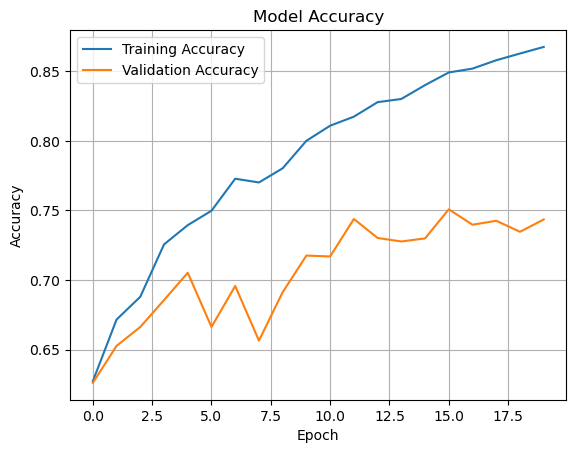

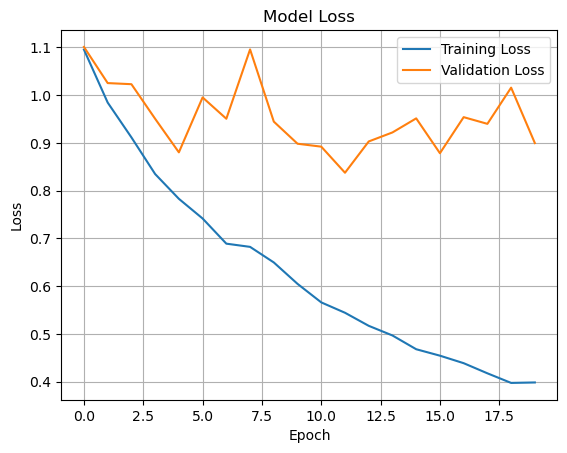

In [15]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

 Step 7: Save Model

In [16]:
model.save("models/waste_classifier.h5")

Test Model with an Image

In [17]:
import os
import numpy as np

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the model
model = load_model('models/waste_classifier.h5')  

# Define image class labels (in same order as training folders)
class_names = ['battery', 'biological', 'cardboard', 'clothes',
               'glass', 'metal', 'paper', 'plastic', 'shoes' ,'trash']

# Image path
img_path = 'data_split/test/biological/biological_112.jpg'  

# Load and preprocess image
img = image.load_img(img_path, target_size=(244, 244))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize same as training

# Predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

print(f"🧾 Predicted Class: {predicted_class}")
print(f"🔢 Probabilities: {dict(zip(class_names, predictions[0]))}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
🧾 Predicted Class: biological
🔢 Probabilities: {'battery': np.float32(0.00091010745), 'biological': np.float32(0.8902463), 'cardboard': np.float32(0.00016501582), 'clothes': np.float32(0.0058405907), 'glass': np.float32(0.09078346), 'metal': np.float32(0.00031308617), 'paper': np.float32(6.6366835e-07), 'plastic': np.float32(1.50985825e-05), 'shoes': np.float32(0.00021621917), 'trash': np.float32(0.011509495)}


Visualize with matplotlib

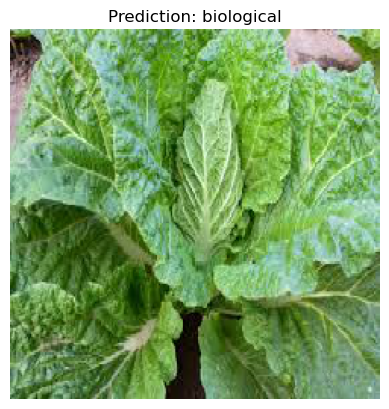

In [18]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Prediction: {predicted_class}")
plt.axis('off')
plt.show()


Class Distribution: Quantity of Images per Folder

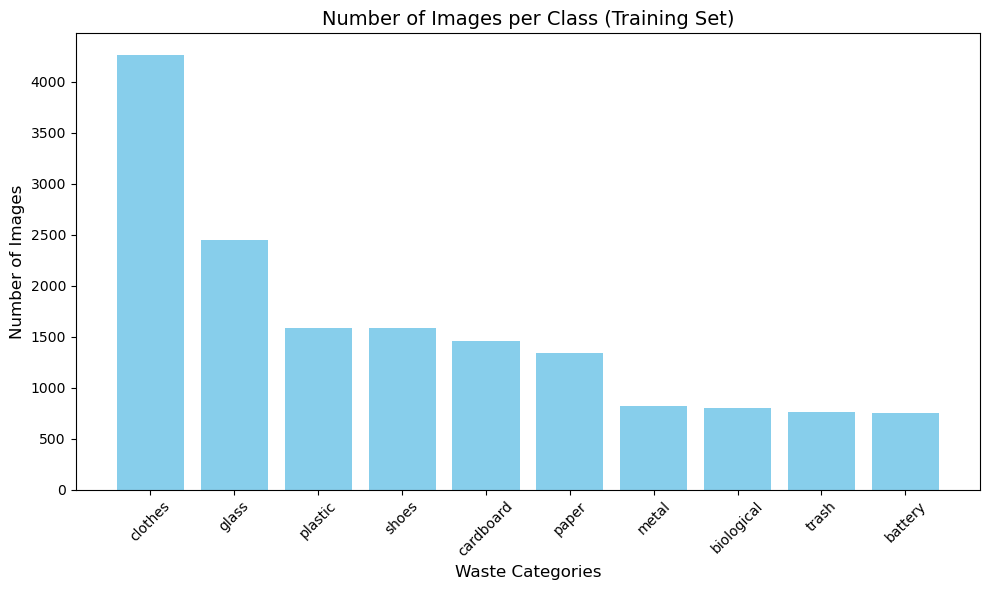

Class Distribution:
clothes: 4261 images
glass: 2448 images
plastic: 1587 images
shoes: 1581 images
cardboard: 1460 images
paper: 1344 images
metal: 816 images
biological: 797 images
trash: 757 images
battery: 755 images


In [21]:

# Define path to the training folder
train_dir = 'data_split/train/'  

# Count number of images in each class
class_counts = {folder: len(os.listdir(os.path.join(train_dir, folder)))
                for folder in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, folder))}

# Sort by count
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Number of Images per Class (Training Set)', fontsize=14)
plt.xlabel('Waste Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print exact numbers
print("Class Distribution:")
for k, v in class_counts.items():
    print(f"{k}: {v} images")
